In [1]:
import pandas as pd

df = pd.read_parquet("/workspace/steering_vectors_trained_activation.parquet")


In [2]:
df

,dataset,trained_or_activation,eval_ppl,steering_vector
0,qwen-3-32b__trait__absolutist,True,2.653719,"[-1.140625, -2.9375, 3.109375, 2.71875, 3.0, -..."
1,qwen-3-32b__trait__absolutist,False,5.102207,"[1.3828125, -0.51171875, 0.20703125, -0.279296..."
2,qwen-3-32b__trait__abstract,True,3.000992,"[-5.5625, 3.21875, 3.09375, 2.25, 5.125, -2.64..."
3,qwen-3-32b__trait__abstract,False,5.473644,"[1.6171875, -0.6484375, 0.0203857421875, -0.34..."
4,qwen-3-32b__trait__accessible,True,2.636016,"[-5.0625, -5.25, -0.15625, 4.3125, 7.3125, -4...."
...,...,...,...,...
433,qwen-3-32b__trait__witty,False,6.794291,"[1.0859375, 0.12255859375, 0.1298828125, -0.63..."
434,qwen-3-32b__trait__wry,True,4.110384,"[-3.84375, -5.3125, 3.78125, 4.21875, -2.9375,..."
435,qwen-3-32b__trait__wry,False,7.895659,"[1.125, 0.3125, 0.185546875, -0.609375, -0.585..."
436,qwen-3-32b__trait__zealous,True,3.096612,"[-3.8125, 3.078125, 4.46875, 1.2578125, 2.0, -..."


In [3]:
import numpy as np

df["steering_vector"] = df["steering_vector"].apply(lambda x: np.array(x))


In [4]:
df

,dataset,trained_or_activation,eval_ppl,steering_vector
0,qwen-3-32b__trait__absolutist,True,2.653719,"[-1.140625, -2.9375, 3.109375, 2.71875, 3.0, -..."
1,qwen-3-32b__trait__absolutist,False,5.102207,"[1.3828125, -0.51171875, 0.20703125, -0.279296..."
2,qwen-3-32b__trait__abstract,True,3.000992,"[-5.5625, 3.21875, 3.09375, 2.25, 5.125, -2.64..."
3,qwen-3-32b__trait__abstract,False,5.473644,"[1.6171875, -0.6484375, 0.0203857421875, -0.34..."
4,qwen-3-32b__trait__accessible,True,2.636016,"[-5.0625, -5.25, -0.15625, 4.3125, 7.3125, -4...."
...,...,...,...,...
433,qwen-3-32b__trait__witty,False,6.794291,"[1.0859375, 0.12255859375, 0.1298828125, -0.63..."
434,qwen-3-32b__trait__wry,True,4.110384,"[-3.84375, -5.3125, 3.78125, 4.21875, -2.9375,..."
435,qwen-3-32b__trait__wry,False,7.895659,"[1.125, 0.3125, 0.185546875, -0.609375, -0.585..."
436,qwen-3-32b__trait__zealous,True,3.096612,"[-3.8125, 3.078125, 4.46875, 1.2578125, 2.0, -..."


In [5]:
df_trained = df[df["trained_or_activation"]]
df_activation = df[~df["trained_or_activation"]]

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Ensure both DataFrames are sorted by dataset for alignment
df_trained_sorted = df_trained.sort_values("dataset").reset_index(drop=True)
df_activation_sorted = df_activation.sort_values("dataset").reset_index(drop=True)

# Sanity check: datasets should match
assert all(df_trained_sorted["dataset"].values == df_activation_sorted["dataset"].values), "Datasets do not align!"

trained_vectors = np.stack(df_trained_sorted["steering_vector"].values)
activation_vectors = np.stack(df_activation_sorted["steering_vector"].values)

# Compute cosine similarity for each pair
cos_sims = np.array([
    cosine_similarity(trained_vec.reshape(1, -1), activation_vec.reshape(1, -1))[0, 0]
    for trained_vec, activation_vec in zip(trained_vectors, activation_vectors)
])

# Add to DataFrame for inspection
df_similarity = pd.DataFrame({
    "dataset": df_trained_sorted["dataset"].values,
    "cosine_similarity": cos_sims
})

df_similarity



,dataset,cosine_similarity
0,qwen-3-32b__trait__absolutist,0.003786
1,qwen-3-32b__trait__abstract,0.009032
2,qwen-3-32b__trait__accessible,0.002368
3,qwen-3-32b__trait__accommodating,0.003448
4,qwen-3-32b__trait__acerbic,-0.000846
...,...,...
214,qwen-3-32b__trait__visceral,0.010226
215,qwen-3-32b__trait__whimsical,-0.001541
216,qwen-3-32b__trait__witty,0.007026
217,qwen-3-32b__trait__wry,-0.010922


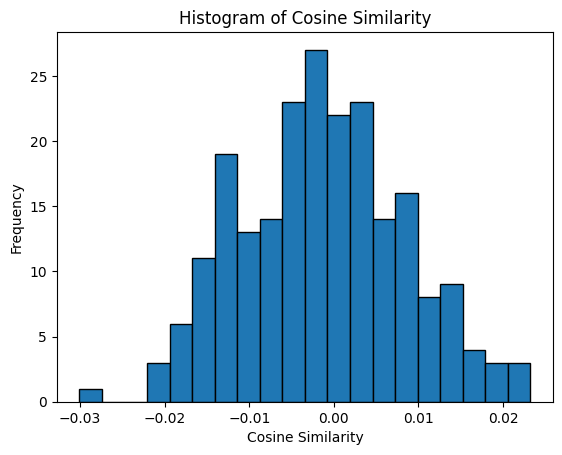

In [9]:
import matplotlib.pyplot as plt
# histogram of cosine similarity
plt.hist(cos_sims, bins=20, edgecolor='black')
plt.title("Histogram of Cosine Similarity")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()


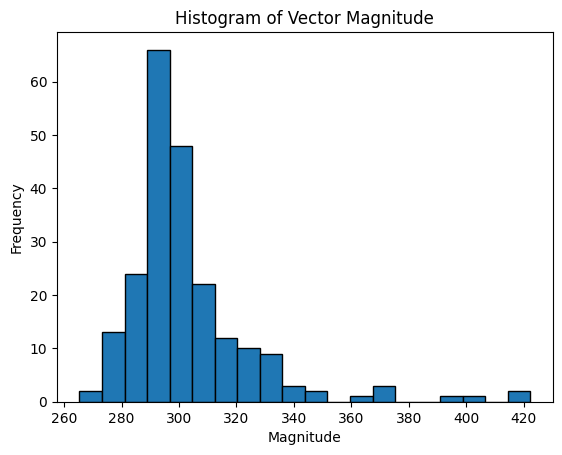

In [10]:
# histogram of vector magnitudes
plt.hist(np.linalg.norm(trained_vectors, axis=1), bins=20, edgecolor='black')
plt.title("Histogram of Vector Magnitude")
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.show()


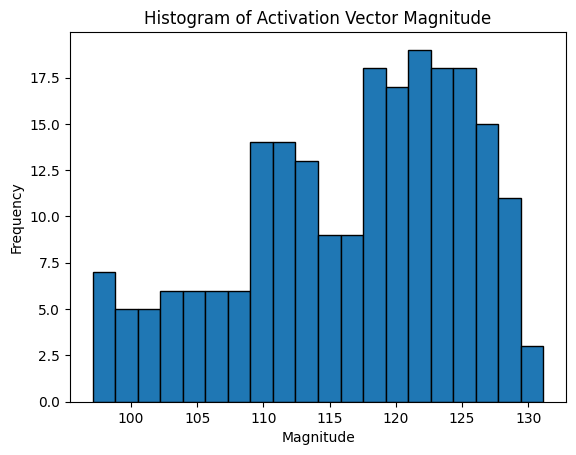

In [11]:
# histogram of activation vector magnitudes
plt.hist(np.linalg.norm(activation_vectors, axis=1), bins=20, edgecolor='black')
plt.title("Histogram of Activation Vector Magnitude")
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.show()


Pearson correlation between vector norms: r=-0.2153, p=0.00135
Spearman correlation between vector norms: r=-0.1307, p=0.05342


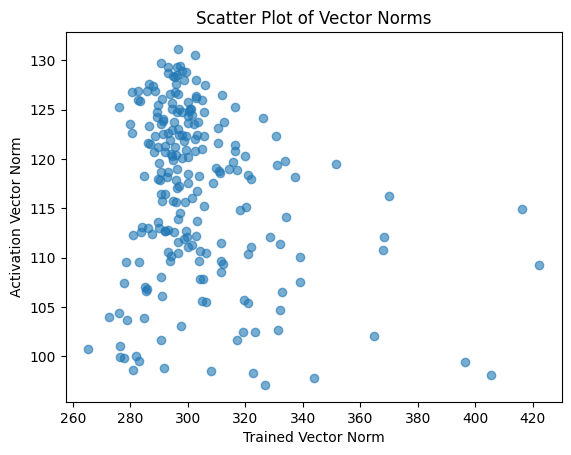

In [14]:
from scipy.stats import pearsonr, spearmanr

# Compute norms
trained_norms = np.linalg.norm(trained_vectors, axis=1)
activation_norms = np.linalg.norm(activation_vectors, axis=1)

# Pearson correlation
pearson_corr, pearson_p = pearsonr(trained_norms, activation_norms)
print(f"Pearson correlation between vector norms: r={pearson_corr:.4f}, p={pearson_p:.4g}")

# Spearman correlation
spearman_corr, spearman_p = spearmanr(trained_norms, activation_norms)
print(f"Spearman correlation between vector norms: r={spearman_corr:.4f}, p={spearman_p:.4g}")

# Optionally, scatter plot
plt.scatter(trained_norms, activation_norms, alpha=0.6)
plt.xlabel("Trained Vector Norm")
plt.ylabel("Activation Vector Norm")
plt.title("Scatter Plot of Vector Norms")
plt.show()
